In [105]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import os
import sys
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\usuar\Desktop\The_Bridge\EDA_F1_Analysis\src\utils")
from funciones_eda import *
from scipy.stats import chi2_contingency
from scipy import stats

Segundo notebook: Análisis gráfico de los datos

Este df es para saber que equipos fueron los campeones de su año. Tan solo cogeremos los datos del equipo campeón que los juntaremos con el de pilotos campeones. El premio de equipo ganador comenzó a darse en 1958, por lo que en años anteriores no se tendrá en cuenta.

In [2]:
# Equipos ganadores del campeonato. Creamos este df para saber cual es el equipo que
# ganó el mundial y juntarlo con el de pilotos ganadores.
url = "https://es.wikipedia.org/wiki/Campeonato_Mundial_de_Constructores_de_F%C3%B3rmula_1"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find_all('table', {'class': 'wikitable sortable'})[0]
rows = table.find_all('tr')
headers = [th.get_text(strip=True) for th in rows[0].find_all('th')]

data = []
for row in rows[1:]:
    cols = row.find_all('td')
    if len(cols) == 12:
        cols = [col.get_text(strip=True) for col in cols]
        data.append(cols)

df_equipos_ganadores = pd.DataFrame(data, columns=headers)

In [3]:
# Creación del df de pilotos campeones de la F1.
url = "https://en.wikipedia.org/wiki/List_of_Formula_One_World_Drivers%27_Champions"

response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")
tabla = soup.find("table", {"class": "wikitable sortable"})
filas = tabla.find_all("tr")
data = []

for fila in filas[1:]:  # Ignora la primera fila que es el encabezado
    cols = fila.find_all("td")
    
    if len(cols) == 16:
        year = cols[0].text.strip()
        driver = cols[1].text.strip()
        age = cols[2].text.strip()
        team = cols[3].text.strip()
        engine = cols[4].text.strip()
        tyres = cols[5].text.strip()
        pole = cols[6].text.strip()
        wins = cols[7].text.strip()
        podiums = cols[8].text.strip()
        fastest_laps = cols[9].text.strip()
        points = cols[10].text.strip()
        percent_points = cols[11].text.strip()
        clinched = cols[12].text.strip()
        rounds_remaining = cols[13].text.strip()
        margin = cols[14].text.strip()
        percent_margin = cols[15].text.strip()
        
        data.append([year, driver, age, team, engine, tyres, pole, wins, 
                     podiums, fastest_laps, points, percent_points, clinched, 
                     rounds_remaining, margin, percent_margin])

df_temporadas_f1 = pd.DataFrame(data, columns=[
    "year", "Driver", "Age", "Team", "Engine", "Tyres", "Pole", 
    "Wins", "Podiums", "Fastest Laps", "Points", "% Points", "Clinched", 
    "# of Rounds Remaining", "Margin", "% Margin"
])

# Eliminar los corchetes y contenido de las columnas que tienen corchetes para limpiar los datos.
for column in df_temporadas_f1.columns:
    for index in range(len(df_temporadas_f1)):
        df_temporadas_f1.at[index, column] = re.sub(r'\[.*?\]', '', str(df_temporadas_f1.at[index, column]))

# Convertir los datos de la variable "Tyres" en un solo valor para poder analizarlo mejor.
df_temporadas_f1["year"] = pd.to_numeric(df_temporadas_f1["year"])
df_temporadas_f1.loc[df_temporadas_f1["Tyres"] == "F P", "Tyres"] = "F"
df_temporadas_f1.loc[df_temporadas_f1["Tyres"] == "M G", "Tyres"] = "G"

# Convertir las variables númericas en tipo "int" y "float".
columnas_cambio_tipo = ["Age","Pole","Wins","Podiums","Fastest Laps","# of Rounds Remaining"]
df_temporadas_f1[columnas_cambio_tipo] = df_temporadas_f1[columnas_cambio_tipo].astype(int)
df_temporadas_f1["Points"] = df_temporadas_f1["Points"].astype(float)

In [83]:
# Añadir filas por encima del df de equipos ganadores para poder juntarlo con el otro y cuadre el número de filas.
diferencia = 75 - len(df_equipos_ganadores)

# Si faltan filas, añadir filas vacías solo al principio.
if diferencia > 0:
    filas_extra = pd.DataFrame( index=range(diferencia), columns=df_equipos_ganadores.columns)
    df_equipos_ganadores = pd.concat([filas_extra, df_equipos_ganadores], ignore_index=True)

df_temporadas_f1["Team_winner"] = df_equipos_ganadores["Constructor"]
# Sustituir los nulos por "Not awarded".
df_temporadas_f1["Team_winner"] = df_temporadas_f1["Team_winner"].fillna("Not awarded")
df_temporadas_f1.to_csv("df_temporadas_f1.csv", index=False)

In [5]:
df_temporadas_f1

,year,Driver,Age,Team,Engine,Tyres,Pole,Wins,Podiums,Fastest Laps,Points,% Points,Clinched,# of Rounds Remaining,Margin,% Margin,Team_winner
0,1950,Giuseppe Farina,44,Alfa Romeo,Alfa Romeo,P,2,3,3,3,30.0,83.333 (47.619),Round 7 of 7,0,3,10.000,Not awarded
1,1951,Juan Manuel Fangio,40,Alfa Romeo,Alfa Romeo,P,4,3,5,5,31.0,86.111 (51.389),Round 8 of 8,0,6,19.355,Not awarded
2,1952,Alberto Ascari,34,Ferrari,Ferrari,F,5,6,6,6,36.0,100.000 (74.306),Round 6 of 8,2,12,33.333,Not awarded
3,1953,Alberto Ascari,35,Ferrari,Ferrari,P,6,5,5,4,34.5,95.833 (57.407),Round 8 of 9,1,6.5,18.841,Not awarded
4,1954,Juan Manuel Fangio,43,Maserati,Maserati,P,5,6,7,3,42.0,93.333 (70.547),Round 7 of 9,2,16.857,40.136,Not awarded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2020,Lewis Hamilton,35,Mercedes,Mercedes,P,10,11,14,6,347.0,78.507,Round 14 of 17,3,124,35.735,Mercedes
71,2021,Max Verstappen,24,Red Bull,Honda,P,10,10,18,6,395.5,69.692,Round 22 of 22,0,8,2.023,Mercedes
72,2022,Max Verstappen,25,Red Bull,RBPT,P,7,15,17,5,454.0,76.174,Round 18 of 22,4,146,32.159,Red Bull
73,2023,Max Verstappen,26,Red Bull,Honda RBPT,P,12,19,21,9,575.0,92.742,Round 17 of 22,5,290,50.435,Red Bull


In [6]:
df_temporadas_f1.describe()

,year,Age,Pole,Wins,Podiums,Fastest Laps,Points,# of Rounds Remaining
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,1987.000000,31.560000,5.960000,6.373333,10.040000,3.960000,134.686667,1.360000
std,21.794495,5.415793,3.699671,3.380282,4.075106,2.373502,135.705981,1.467117
min,1950.000000,23.000000,0.000000,1.000000,3.000000,0.000000,30.000000,0.000000
25%,1968.500000,28.000000,3.000000,4.000000,7.000000,2.000000,50.500000,0.000000
50%,1987.000000,31.000000,6.000000,6.000000,10.000000,3.000000,73.000000,1.000000
75%,2005.500000,34.000000,9.000000,8.500000,12.000000,6.000000,128.000000,2.000000
max,2024.000000,46.000000,15.000000,19.000000,21.000000,10.000000,575.000000,6.000000


En este primer análisis se pueden observar varias cosas. La de edad media de los pilotos campeones es de 31 - 32 años. La media de carreras ganadas por temporada es de 6-7. La media de podiums (1er, 2do o 3er puesto) ganados en una temporada por un piloto campeón es de 10. 

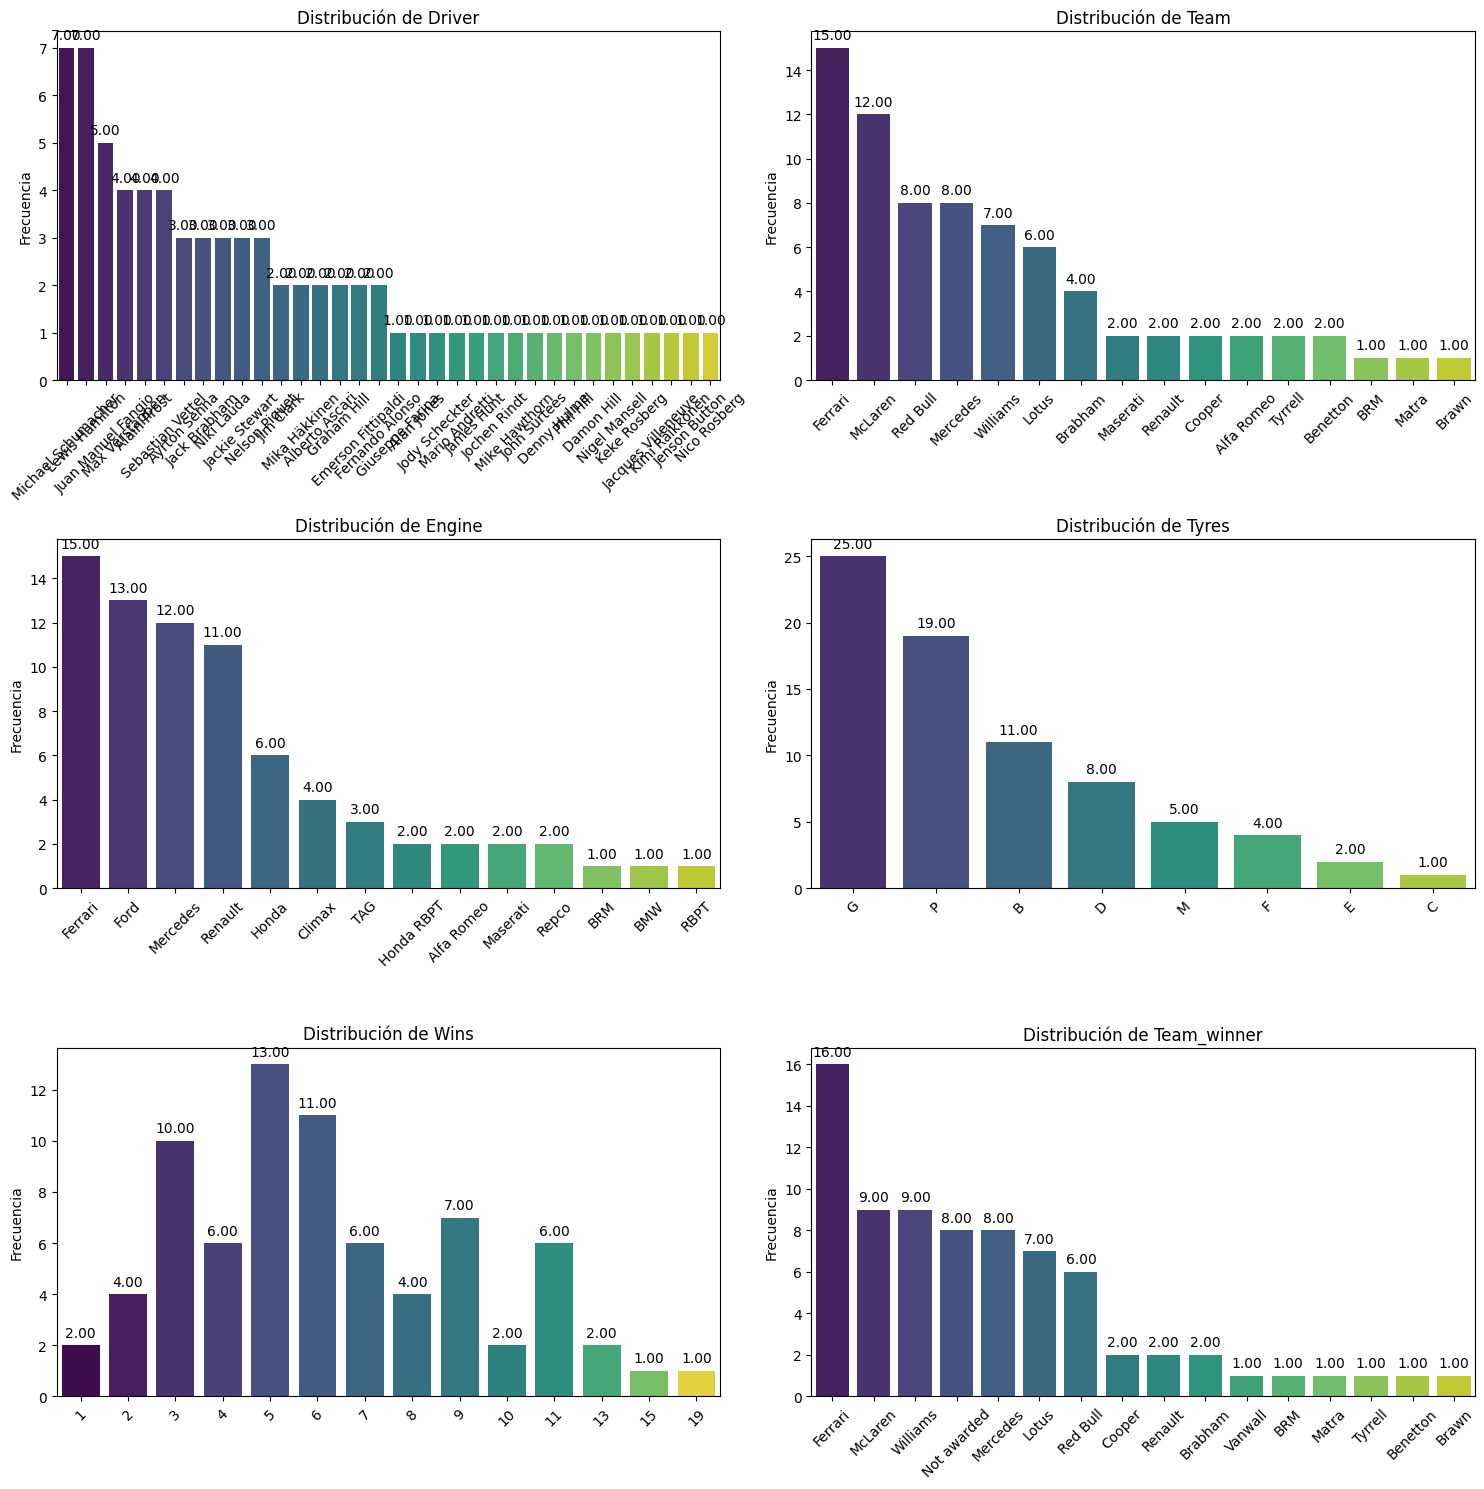

In [87]:
categoricas_temporadas = ["Driver","Team","Engine","Tyres","Wins","Team_winner"]
pinta_distribucion_categoricas(df_temporadas_f1, categoricas_temporadas, mostrar_valores=True)

Los pilotos con más mundiales son Michael Schumacher y Lewis Hamilton, ambos con 7 mundiales. El equipo con más títulos es Ferrari, con un total de 16 títulos mundiales seguido de Mclaren y Williams, con un total de 9 mundiales cada uno.

A primera vista se podría decir que si un piloto corre para Ferrari, Mclaren o Williams es más probable que gane un mundial que si corre para otro equipo.

In [72]:
df_temporadas_f1.groupby("Team")[["Driver"]].describe()

Driver                                
            count unique                 top freq
Team                                             
Alfa Romeo      2      2     Giuseppe Farina    1
BRM             1      1         Graham Hill    1
Benetton        2      1  Michael Schumacher    2
Brabham         4      3       Nelson Piquet    2
Brawn           1      1       Jenson Button    1
Cooper          2      1        Jack Brabham    2
Ferrari        15      9  Michael Schumacher    5
Lotus           6      5           Jim Clark    2
Maserati        2      1  Juan Manuel Fangio    2
Matra           1      1      Jackie Stewart    1
McLaren        12      7         Alain Prost    3
Mercedes        8      3      Lewis Hamilton    6
Red Bull        8      2    Sebastian Vettel    4
Renault         2      1     Fernando Alonso    2
Tyrrell         2      1      Jackie Stewart    2
Williams        7      7          Alan Jones    1

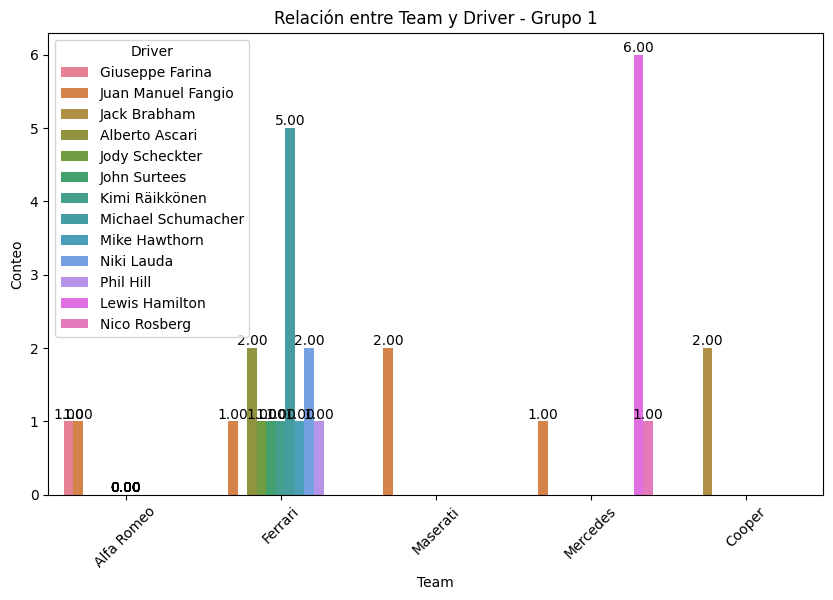

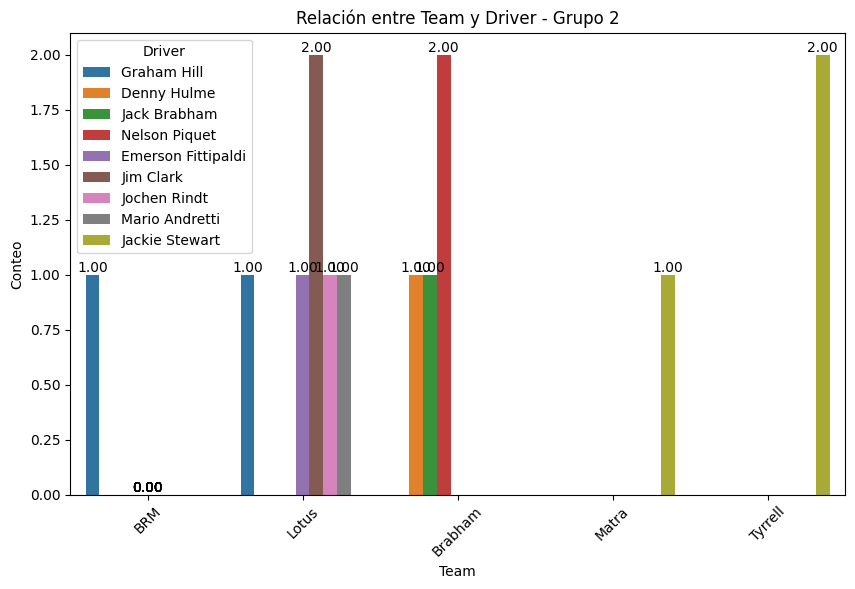

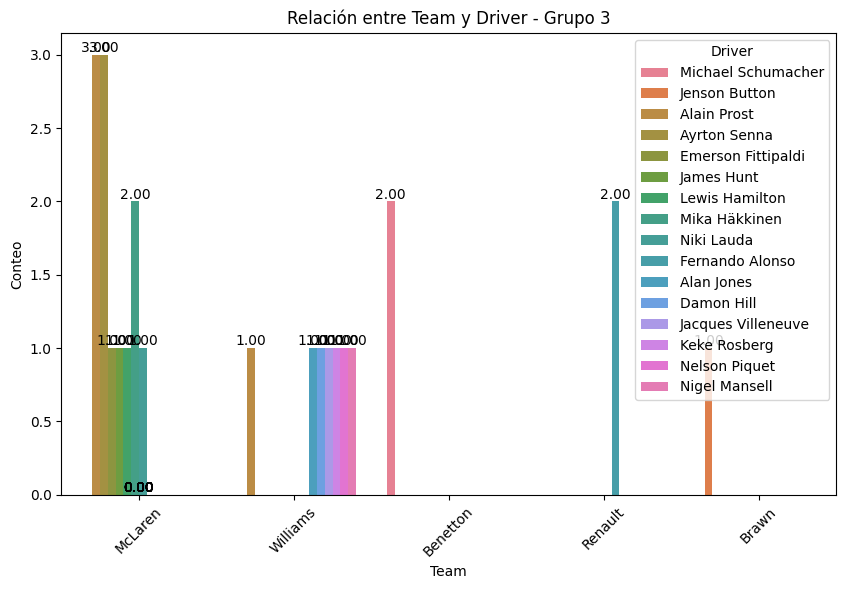

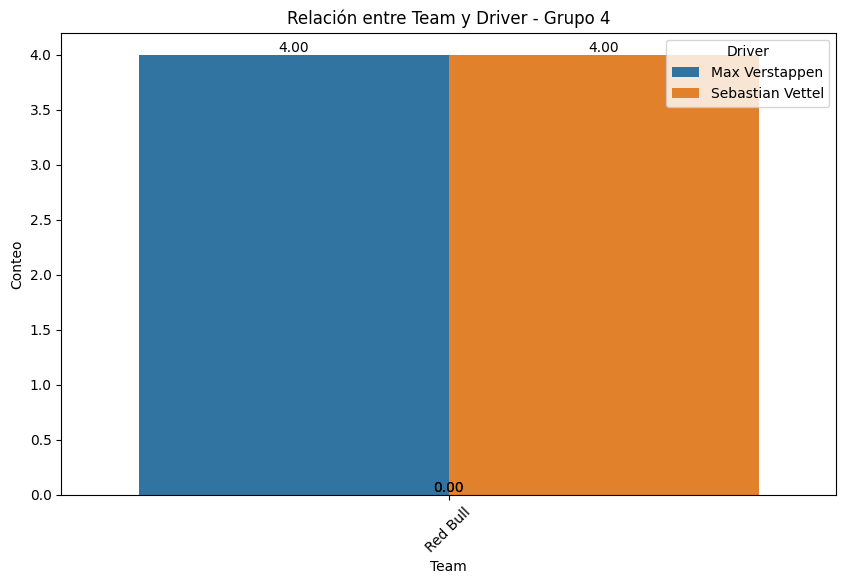

In [49]:
top_equipos = df_temporadas_f1["Driver"].value_counts().index
top_status = df_temporadas_f1["Team"].value_counts().index
df_filtrado = df_temporadas_f1[df_temporadas_f1["Driver"].isin(top_equipos) & df_temporadas_f1["Team"].isin(top_status)]

plot_categorical_relationship_fin(df_filtrado, "Team", "Driver", show_values=True)

En los datos anteriores se puede observar que los equipos con la mayor cantidad de campeonatos de pilotos son Ferrari (15), Mclaren (12), Mercedes(8) y Red Bull (8). Esto nos puede decir dos cosas: los equipos han sabido elegir a sus pilotos o que los equipos han sabido hacer el mejor coche.

In [91]:
tabla_contingencia = pd.crosstab(df_temporadas_f1["Driver"], df_temporadas_f1["Team"])
tabla_contingencia
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
# print("Tabla de Frecuencias Esperadas:\n", expected)

Valor Chi-Cuadrado: 758.9017857142858
P-Value: 1.9664347121245177e-13
Grados de Libertad: 495


Al analizar las variables categóricas "Driver" y "Team" podemos decir que tienen una fuerte relación estadística. Con un p-value inferior a 0.05 podemos rechazar la hipótesis nula y decir que los campeonatos que consigue un piloto están relacionados con el equipo que elige.

Análisis de la variable "wins". 

(2,)


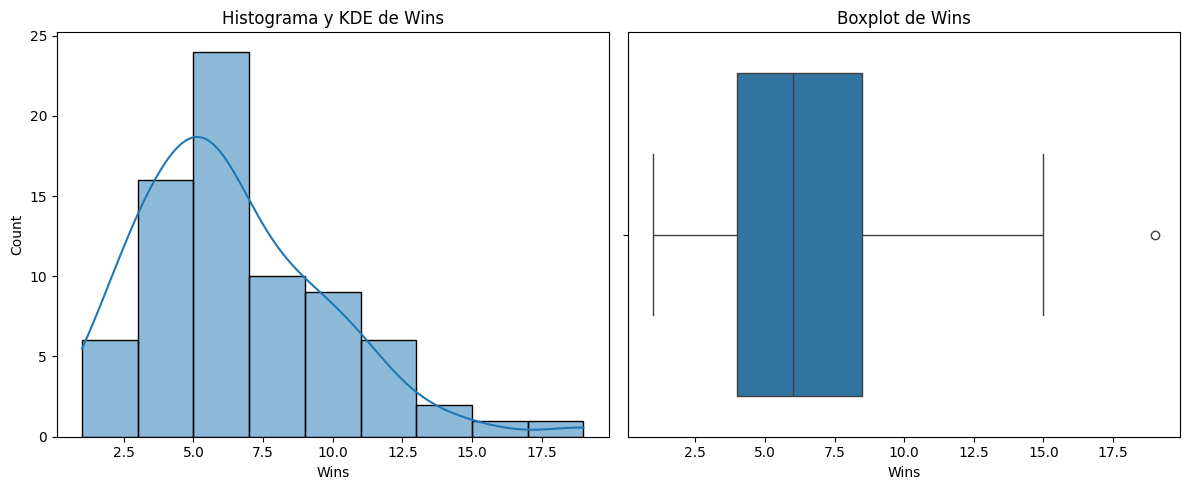

In [94]:
plot_combined_graphs(df_temporadas_f1, ["Wins"])

Análisis de las victorias que consigue un equipo.

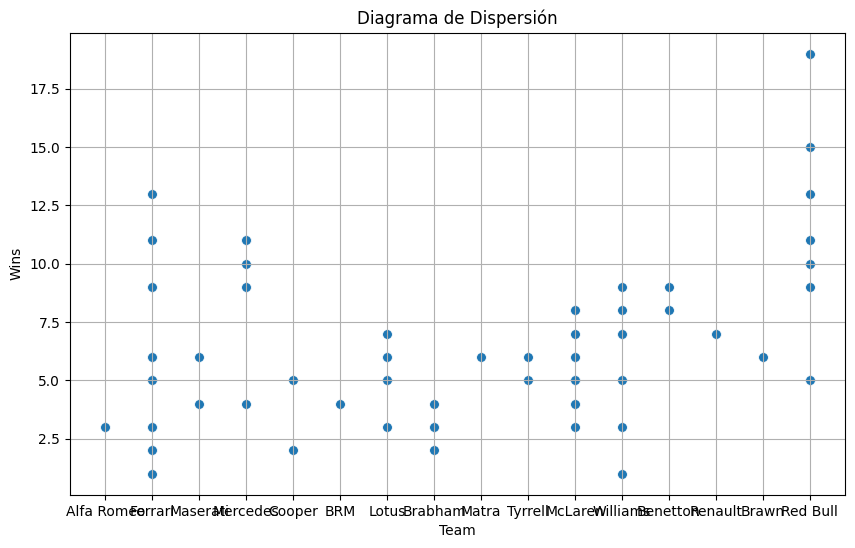

In [99]:
grafico_dispersion_con_correlacion(df_temporadas_f1, "Team", "Wins")

Para ver si hay una relación estadística entre estas dos variables, realizamos el test ANOVA.

In [106]:
grupos = df_temporadas_f1["Team"].unique()  # Obtener los valores únicos de la columna categórica, en este caso la compañía área
ingresos_por_company = [df_temporadas_f1[df_temporadas_f1["Team"] == grupo]['Wins'] for grupo in grupos] # obtenemos los ingresos por compañía y los incluimos en una lista

f_val, p_val = stats.f_oneway(*ingresos_por_company) # El método * (igual que cuando vimos *args hace mil años) 
                                                    # lo que hace es separar todos los elementos de la lista y pasarselos como argumento a la función
print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 3.116818680038394
Valor p: 0.0009154979405189027


DF COMBINADO
En df tiene todas las carreras disputadas en la F1 desde 1950 hasta 2024.

In [9]:
# Extracción de los datos para crear el df.
circuits = pd.read_csv("../data/f1_data/circuits.csv")
constructors = pd.read_csv("../data/f1_data/constructors.csv")
constructor_results = pd.read_csv("../data/f1_data/constructor_results.csv")
constructor_standings = pd.read_csv("../data/f1_data/constructor_standings.csv")
drivers = pd.read_csv("../data/f1_data/drivers.csv")
driver_standings = pd.read_csv("../data/f1_data/driver_standings.csv")
lap_times = pd.read_csv("../data/f1_data/lap_times.csv")
pit_stops = pd.read_csv("../data/f1_data/pit_stops.csv")
qualifying = pd.read_csv("../data/f1_data/qualifying.csv")
races = pd.read_csv("../data/f1_data/races.csv")
results = pd.read_csv("../data/f1_data/results.csv")
seasons = pd.read_csv("../data/f1_data/seasons.csv")
status = pd.read_csv("../data/f1_data/status.csv")

df_combinado = pd.merge(results, races, on='raceId', how='left')

df_combinado = pd.merge(df_combinado, drivers, on='driverId', how='left')

if 'constructorId' in constructors.columns:
    df_combinado = pd.merge(df_combinado, constructors, on='constructorId', how='left')

if 'constructorId' in constructor_results.columns:
    df_combinado = pd.merge(df_combinado, constructor_results, on=['raceId', 'constructorId'], how='left')

if 'constructorId' in constructor_standings.columns:
    df_combinado = pd.merge(df_combinado, constructor_standings, on=['raceId', 'constructorId'], how='left')

if 'raceId' in qualifying.columns and 'driverId' in qualifying.columns:
    df_combinado = pd.merge(df_combinado, qualifying, on=['raceId', 'driverId'], how='left', suffixes=('', '_qualifying'))

df_combinado = df_combinado.loc[:, ~df_combinado.columns.str.endswith('_qualifying')]

if 'raceId' in driver_standings.columns and 'driverId' in driver_standings.columns:
    df_combinado = pd.merge(df_combinado, driver_standings, on=['raceId', 'driverId'], how='left', suffixes=('', '_driver_standings'))

# Eliminar las columnas duplicadas si ya existen en el DataFrame
df_combinado = df_combinado.loc[:, ~df_combinado.columns.str.endswith('_driver_standings')]

if 'year' in seasons.columns:
    df_combinado = pd.merge(df_combinado, seasons, on='year', how='left', suffixes=('', '_seasons'))

    df_combinado = df_combinado.loc[:, ~df_combinado.columns.str.endswith('_seasons')]
    
if 'statusId' in status.columns:
    df_combinado = pd.merge(df_combinado, status, on='statusId', how='left')

# Eliminación de duplicados.
df_combinado = df_combinado.drop_duplicates()
pd.set_option("display.max_columns", None)

# Eliminar colunmas que no nos interesan.
df_combinado.drop(columns=["url_x","url_y","url","quali_date","quali_time","sprint_date","sprint_time",
                          "name_y","surname","fp1_date","fp1_time","fp2_date","fp2_time",
                          "fp3_date","fp3_time","milliseconds","time_y","positionText_x","number_y",
                          "positionText_y","driverId","qualifyId","number","statusId","resultId","constructorId",
                          "positionText","rank","driverStandingsId","status_x","constructorResultsId",
                          "constructorStandingsId","position","circuitId"], inplace = True)

# Renombrar columnas para entenderlas.
df_combinado.rename(columns={"nationality_y":"team_nation","nationality_x":"driver_nation","constructorRef":"team",
                            "date":"race_date","name_x":"grand_prix_name","time_x":"driver_race_time",
                            "position_x":"driver_race_position","number_x":"car_number","points_x":"driver_points",
                            "wins":"team_wins","points_y":"team_points","position_y":"team_position",
                            "status_y":"driver_race_status","points":"total_points"}, inplace=True)
df_combinado[df_combinado["year"] == 2024]

,raceId,car_number,grid,driver_race_position,positionOrder,driver_points,laps,driver_race_time,fastestLap,fastestLapTime,fastestLapSpeed,year,round,grand_prix_name,race_date,driverRef,code,forename,dob,driver_nation,team,team_nation,team_points,total_points,team_position,team_wins,q1,q2,q3,driver_race_status
26280,1121,1,1,1,1,26.0,57,1:31:44.742,39,1:32.608,210.383,2024,1,Bahrain Grand Prix,2024-03-02,max_verstappen,VER,Max,1997-09-30,Dutch,red_bull,Austrian,44.0,44.0,1.0,1.0,1:30.031,1:29.374,1:29.179,Finished
26281,1121,11,5,2,2,18.0,57,+22.457,40,1:34.364,206.468,2024,1,Bahrain Grand Prix,2024-03-02,perez,PER,Sergio,1990-01-26,Mexican,red_bull,Austrian,44.0,44.0,1.0,1.0,1:30.221,1:29.932,1:29.537,Finished
26282,1121,55,4,3,3,15.0,57,+25.110,44,1:34.507,206.156,2024,1,Bahrain Grand Prix,2024-03-02,sainz,SAI,Carlos,1994-09-01,Spanish,ferrari,Italian,27.0,27.0,2.0,0.0,1:29.909,1:29.573,1:29.507,Finished
26283,1121,16,2,4,4,12.0,57,+39.669,36,1:34.090,207.069,2024,1,Bahrain Grand Prix,2024-03-02,leclerc,LEC,Charles,1997-10-16,Monegasque,ferrari,Italian,27.0,27.0,2.0,0.0,1:30.243,1:29.165,1:29.407,Finished
26284,1121,63,3,5,5,10.0,57,+46.788,40,1:35.065,204.946,2024,1,Bahrain Grand Prix,2024-03-02,russell,RUS,George,1998-02-15,British,mercedes,German,16.0,16.0,3.0,0.0,1:30.350,1:29.922,1:29.485,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26514,1132,31,18,16,16,0.0,50,\N,46,1:30.875,233.371,2024,12,British Grand Prix,2024-07-07,ocon,OCO,Esteban,1996-09-17,French,alpine,French,0.0,9.0,8.0,0.0,1:34.557,\N,\N,+2 Laps
26515,1132,11,0,17,17,0.0,50,\N,50,1:29.707,236.409,2024,12,British Grand Prix,2024-07-07,perez,PER,Sergio,1990-01-26,Mexican,red_bull,Austrian,18.0,373.0,1.0,7.0,1:38.348,\N,\N,+2 Laps
26516,1132,24,14,18,18,0.0,50,\N,43,1:31.014,233.014,2024,12,British Grand Prix,2024-07-07,zhou,ZHO,Guanyu,1999-05-30,Chinese,sauber,Swiss,0.0,0.0,10.0,0.0,1:31.190,1:27.867,\N,+2 Laps
26517,1132,63,1,\N,19,0.0,33,\N,3,1:31.298,232.289,2024,12,British Grand Prix,2024-07-07,russell,RUS,George,1998-02-15,British,mercedes,German,25.0,221.0,4.0,2.0,1:30.106,1:26.723,1:25.819,Water pressure


En la siguiente gráfica se muestra el total de carreras en las que han participado los equipos.

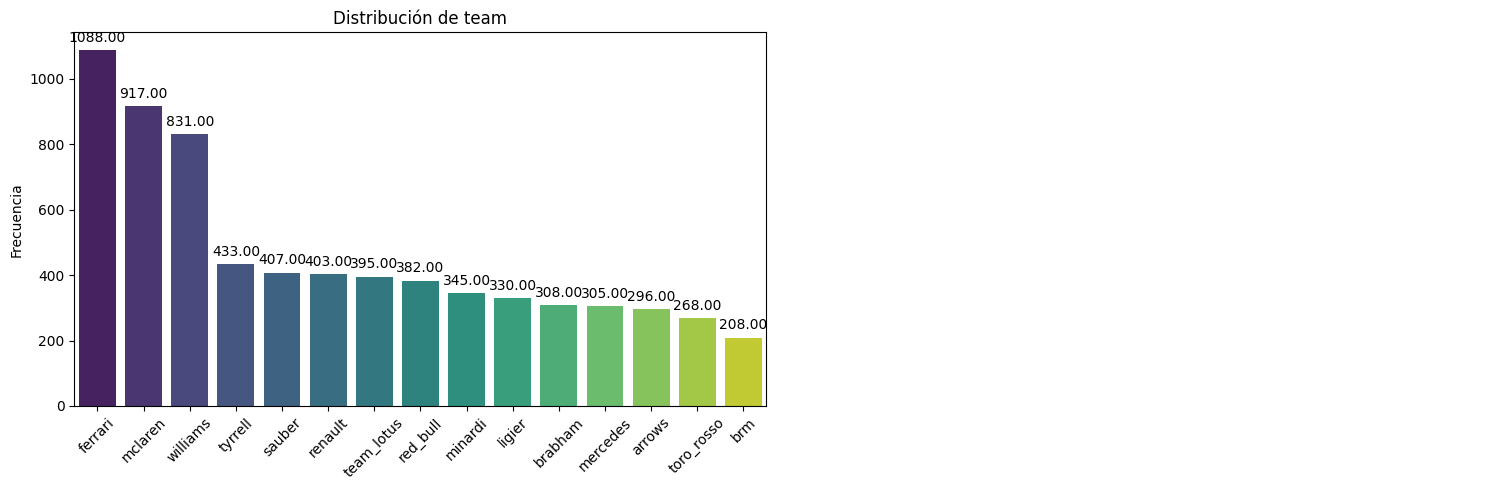

In [80]:
# Eliminar duplicados para cada equipo en una carrera
carreras_equipo = df_combinado.drop_duplicates(subset=["raceId", "team"])
conteo_equipo = df_combinado['team'].value_counts()

# Obtener los equipos más frecuentes
df_top_10_teams = conteo_equipo.head(15).index

# Filtrar el DataFrame original para incluir solo los equipos seleccionados
df_filtrado = carreras_equipo[carreras_equipo['team'].isin(df_top_10_teams)]

pinta_distribucion_categoricas(df_filtrado, ['team'], relativa=False, mostrar_valores=True)

Se puede observar un gran salto entre los 3 primeros equipos y el resto. Los 3 primeros son Ferrari, Mclaren y Williams. Esto nos indica que estos tres equipos llevan compitiendo en la F1 desde los inicios, mientras que el resto de equipos han competido durante periodos concretos de tiempo.

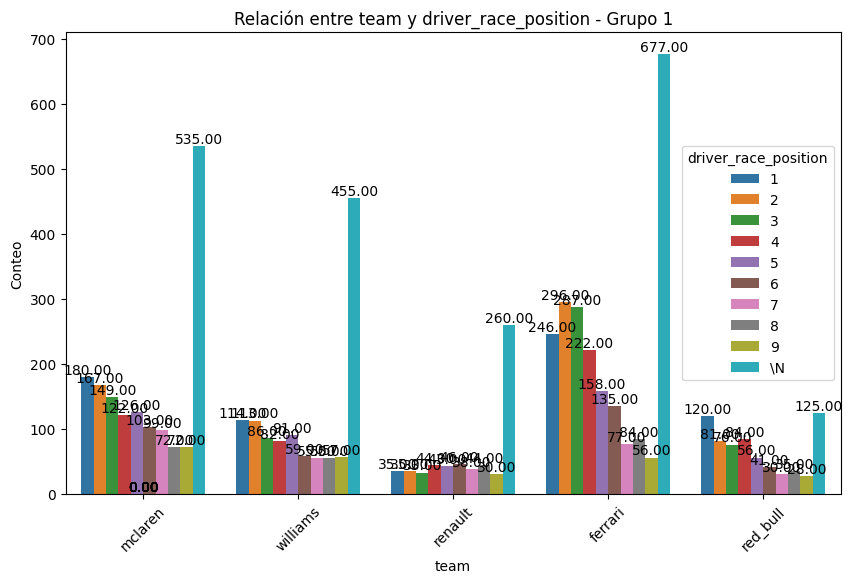

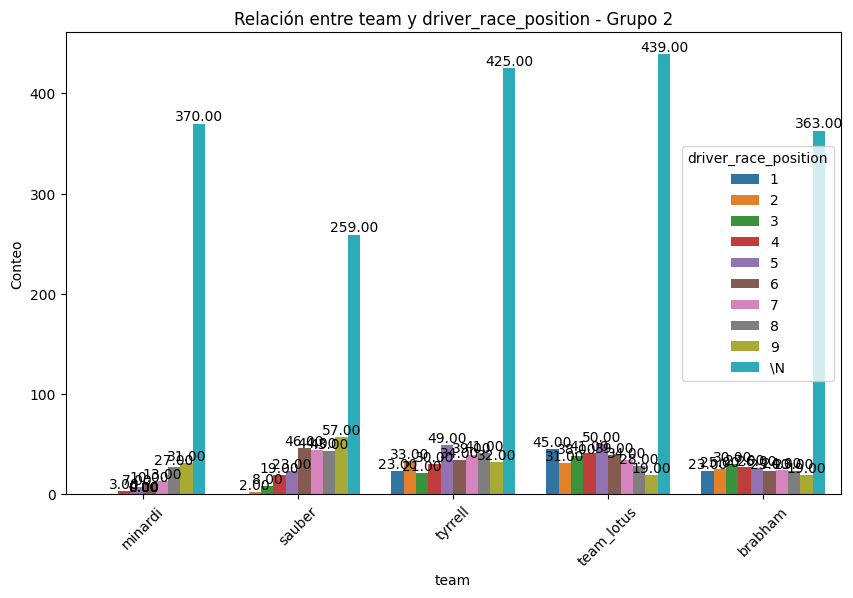

In [51]:
# Limitar el número de categorías a graficar
top_equipos = df_combinado["team"].value_counts().head(10).index
top_status = df_combinado["driver_race_position"].value_counts().head(10).index

# Filtrar los datos para mostrar solo los top 10
df_filtrado = df_combinado[df_combinado["team"].isin(top_equipos) & df_combinado["driver_race_position"].isin(top_status)]

# Ahora podemos usar la función para graficar
plot_categorical_relationship_fin(df_filtrado, "team", "driver_race_position", show_values=True)

En estas gráficas podemos observar la cantidad de veces que han quedado los equipos en cada posición. Ferrari es el equipo que más  victorias ha conseguido, con un total de 246 victorias. El segundo equipo con mayor cantidad de victorias es mclaren, con un total de 180 victorias. El equipo con mayor cantidad de veces con posiciones inferiores a 9º es el equipo lotus, con un total de 439. Ferrari es un equipo que lleva en la Fórmula 1 desde los inicios mientras que Lotus ha estado en periodos de tiempo concretos, por lo que habría que ver de manera relativa cuántas carreras a quedado en una posición inferior a 9º.

Los siguientes gráficos muestran las posiciones de los 10 equipos principales en la F1 de manera relativa. Como no todos los equipos han estado el mismo tiempo, así podremos saber sus resultados con respecto a las carreras que realizaron.

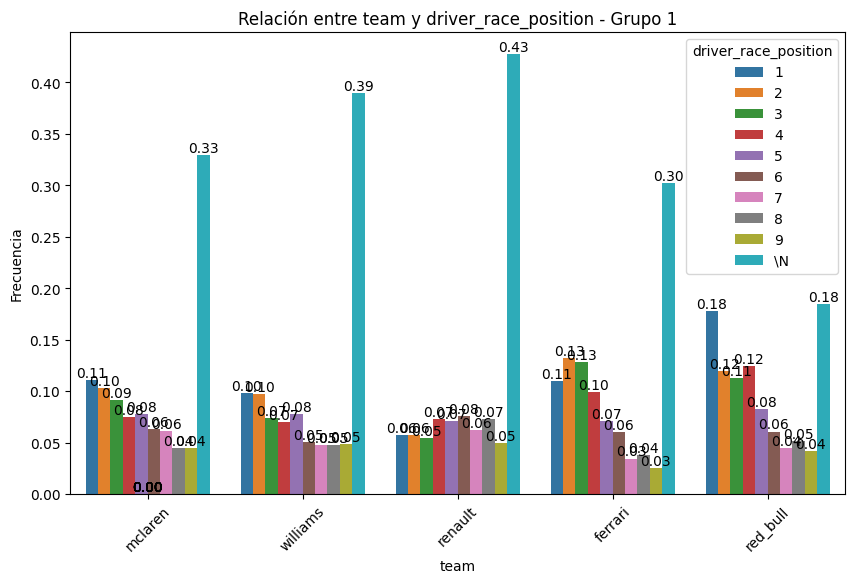

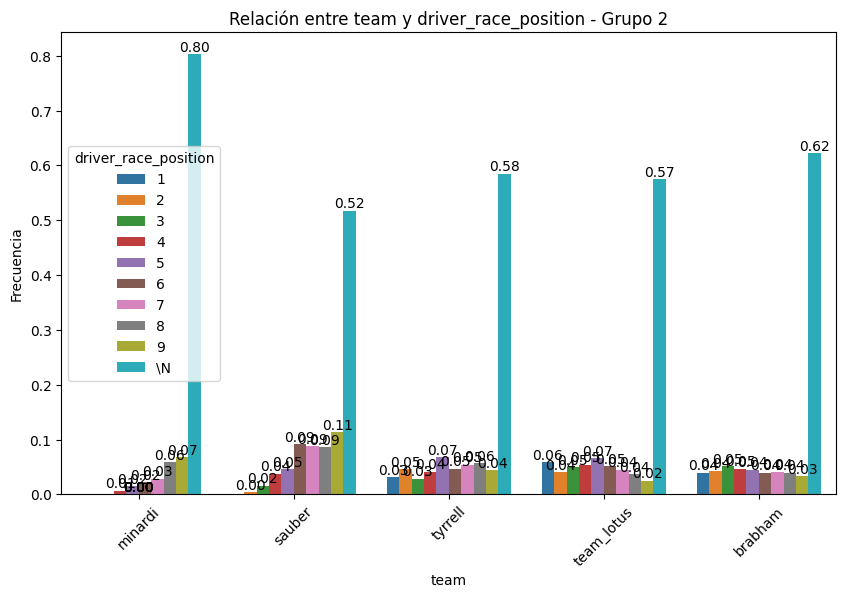

In [15]:
plot_categorical_relationship_fin(df_filtrado, "team", "driver_race_position", show_values=True, relative_freq=True)

Podemos observar que el equipo con la mayor cantidad de 1ª posiciones es red bull, con un 18% de todas las carreras en las que ha competido. El equipo Ferrari pasa a la 2ª posición junto con Mclaren, ambos equipos con un 11% en la 1ª posición. Esto nos muestra que el equipo red bull ha tenido un desempeño muy bueno durante el periodo de tiempo que lleva en la F1 (desde 2005). 

Redbull también cuenta con el menor porcentaje de posiciones por debajo de la 9ª posición, con un 18%.

(2,)


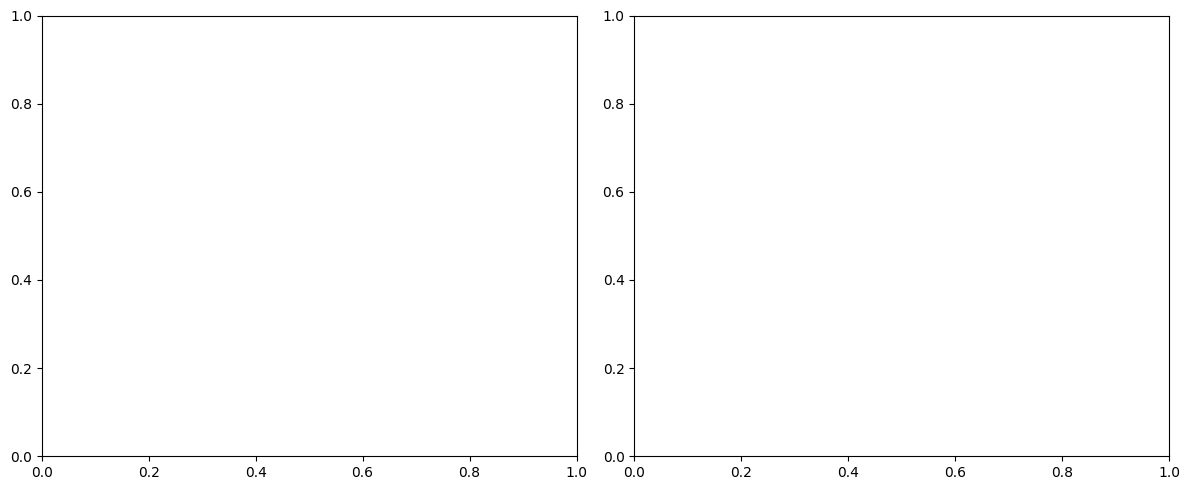

In [102]:
plot_combined_graphs(df_combinado, ["driver_race_position"])